<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Recomendando el Blog de  Hernán Casciari 


[Hernán Casciari](https://hernancasciari.com/#bio), es un escritor argentino, que escribe blog posts con cuentos e historias  relacionadas con el futbol, su vida, infancia, y relaciones familiares con toques de ficción. Este [blog](https://hernancasciari.com/blog/) es  tan interesantes que en 2005 fue premiado como “El mejor blog del mundo” por Deutsche Welle de Alemania. 

El objetivo de este caso-taller es construir un sistema de recomendación basado en los contenidos de los posts utilizando similitud de las palabras usadas o temas de los cuentos.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "Revisión por el compañero."

4. El archivo entregado debe poder ser ejecutado localmente por los pares. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos  en la misma ruta de acceso del cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos 

En la carpeta `data` se encuentran el archivo `blog_casciari.csv` con el título, la fecha de publicación, y el contenido de los cuentos publicados en el blog  de sr. Casciari. Cargue estos datos en su *cuaderno* y reporte brevemente el contenido de la base.
   

In [54]:
# Cargar librerias necesarias para el desarrollo del presente proyecto
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import re
import unidecode
import spacy
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from pprint import pprint
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from sklearn.decomposition import LatentDirichletAllocation
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\Asus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
# Se cargan los datos requeridos y solicitados
data = pd.read_csv('data/blog_casciari.csv')

In [3]:
# Se muestra la estructura del dataset
data.shape

(520, 3)

In [4]:
# Mostramos un preview del dataset
data.head()

,titulo,fecha,cuento
0,El rincón blanco,1/11/08,De pronto yo estaba en el hogar donde pasé la ...
1,Mínimos avances en la cama,1/24/08,"Menos la cama, todo ha mejorado en este mundo...."
2,Don Marcos,2/19/08,"Dos veces, y no una, mi abuelo materno me ayud..."
3,Los dos rulfos,3/26/08,"A su regreso de México, mi amigo Comequechu no..."
4,La noticia no es el perro,4/15/08,"De repente, un video de You Tube recibe un mil..."


In [5]:
# Revisamos el tipo de dato de cada columna del dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   titulo  520 non-null    object
 1   fecha   520 non-null    object
 2   cuento  520 non-null    object
dtypes: object(3)
memory usage: 12.3+ KB


In [6]:
# Verificamos que no haya ningún cuento duplicado
len(data['titulo'].unique())

520

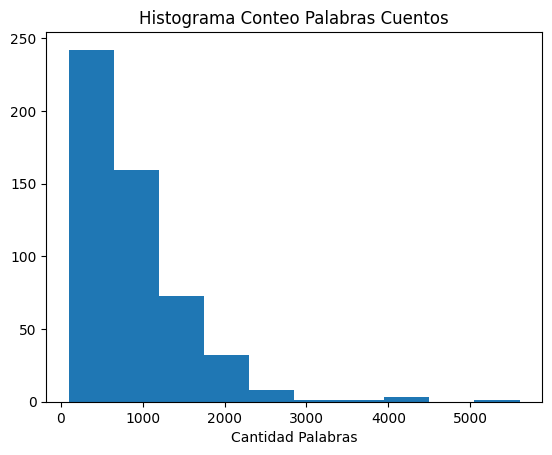

In [7]:
# Revisamos brevemente la distribución del conteo de palabras por cuento
data_dup = data.copy()
data_dup['conteo_palabras'] = data_dup['cuento'].apply(lambda x: len(x.split()))
plt.title('Histograma Conteo Palabras Cuentos')
plt.xlabel('Cantidad Palabras')
plt.hist(data_dup['conteo_palabras'])
plt.show()

Como es posible observar, el contenido de la base consta de 3 columnas (titulo, fecha y cuento), que representan cada uno el nombre, contenido y fecha de publicación de un cuento del blog de Hernán Casciari. Asimismo, el set consta de 520 registros, es decir, 520 cuentos sin valores vacíos, donde cada columna es del tipo categórico evidentemente. Adicionalmente, se observa que la mayor cantidad de cuentos poseen alrededor de 1000 y 1500 palabras.

### 2. Homogenización de textos

Para cumplir con el objetivo de generar recomendaciones en esta sección debe preparar los posts para poder ser utilizados en su sistema de recomendación. Para ello, "limpie" y "tokenize" cada uno de los cuentos, describiendo detalladamente los pasos que realizo y si transformó o eliminó ciertas palabras. Para asistirlo en la tarea he creado listas de *stopwords* que están disponibles en la carpeta `data`. En su procedimiento ilustre la limpieza con el cuento 'La venganza del metegol'. (En su limpieza recuerde que el objetivo es generar recomendaciones a partir de la similitud de las palabras o temas de los cuentos)

In [8]:
stop1 = pd.read_csv('data\stopwords_taller.csv',header=None)
stop1.head()

,0
0,ahora
1,alejandro
2,alex
3,alfonso
4,alguien


In [9]:
stop2 = pd.read_csv('data\extra_stopwords.csv',header=None)
stop2.head()

,0
0,de
1,la
2,que
3,el
4,en


In [10]:
stop = pd.concat([stop1, stop2], ignore_index=True)
stop.head()

,0
0,ahora
1,alejandro
2,alex
3,alfonso
4,alguien


### Eliminación de caracteres no deseados

In [11]:
# Eliminamos las tildes y caracteres especiales del idioma español
data['cuento'] = data['cuento'].apply(lambda x: unidecode.unidecode(x))

In [12]:
# Eliminamos signos de puntuación y cualquier otro carácter no alfa numerico
data['cuento'] = data['cuento'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
data['cuento'] = data['cuento'].apply(lambda x: re.sub('\s+', ' ', x))

In [13]:
# Se eliminan numeros y mas espacios
data['cuento'] = data['cuento'].apply(lambda x: re.sub("\d+", "", x))
data['cuento'] = data['cuento'].apply(lambda x: re.sub('\s+', ' ', x))
data['cuento'] = data['cuento'].apply(lambda x: x.strip())

In [14]:
# Se eliminan saltos de pagina \n
data['cuento'] = data['cuento'].apply(lambda x: re.sub("[^\\w\\s]|\n", ' ', x))

### Conversión a minúsculas 

In [15]:
# Se pasan todas las palabras a minuscula
data['cuento'] = data['cuento'].apply(lambda x: x.lower())

### Eliminación de palabras vacías (stopwords)

In [16]:
# Función para eliminar las stopwords
def del_stop(texto, stopwords):
    return ' '.join([palabra for palabra in texto.split() if palabra not in stopwords])
data['cuento'] = data['cuento'].apply(lambda x: del_stop(x, stop.iloc[:, 0].tolist()))

### Tokenización

In [17]:
# Cargar el modelo para el idioma deseado (por ejemplo, español)
nlp = spacy.load("es_core_news_sm")

C:\Users\Asus\anaconda3\lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [18]:
data['doc'] = data['cuento'].apply(lambda x: nlp(x))

In [19]:
# Configurar pandas para mostrar texto completo en las celdas
pd.set_option('display.max_colwidth', None)

# Mostrar el contenido completo del cuento La venganza del metegol despues de las correciones
print(data['cuento'][data['titulo'] == 'La venganza del metegol'].values[0])

mes pasado invitaron presentar buenos aires futbol final charla director editorial invito jugar partido metegol invento espanol creadores llaman erroneamente futbolin hacia anos jugaba metegol suerte toco companero filosofo prestigioso pudimos ganar contrincantes autor director editorial ultimo conocia juventud jugamos partidos enteros destrozamos facilidad pasmosa hacia anos practicaba falso deporte munecas reflejos descubri habia perdido manas hizo sentir edad cualquier destreza mantengamos indemne mas pelotuda convierte gran noticia despues charla fotografos hicieron imagenes partido metegol subieron twitter estadio libreria gandhi buenos aires locales izquierda duchini gonzalo garces vistantes derecha tomas abraham resultado match match paliza volvi recibi mail amigo infancia decia habia visto fotos sorprendia companero filosofo admirabamos juventud jugando metegol tomas abraham pasar sueno decia verdad partido imagine diecisiete anos mirando ventana libreria gandhi escena futuro s

El procedimiento de limpieza consistió en la eliminación de caracteres no deseados, tales como acentuaciones, números, espacios, signos de puntación y otros caracteres especiales inherentes al idioma español. Posteriormente, se convierten todas las letras a minúscula para estandarizar las palabras. El siguiente paso consiste en eliminar las stop words dadas por el material de este proyecto. Finalmente se tokenizan todos los cuentos dentro del dataset de interés.

### 3. Generando Recomendaciones

En esta sección nos interesa generar recomendaciones de cuentos en el blog a un usuario que leyó 'La venganza del metegol'. Para ello vamos a utilizar distintas estrategias.

#### 3.1. Recomendaciones basadas en contenidos

##### 3.1.1. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para el cuento 'La venganza del metegol' usando en la distancia de coseno donde el texto este vectorizado por `CountVectorizer`. Explique el procedimiento que realizó y como ordenó las recomendaciones.

In [20]:
def recomendador(title, df=data,cantidad=5,metric='cos',method='count'):
    if method == 'count':
        # Definimos el objeto CountVectorizer
        count = CountVectorizer()
        # construimos la matriz CountVectorizer
        matrix = count.fit_transform(df['cuento'])
    elif method == 'tfidf':
        # Creamos una lista con todos los cuentos
        lista = list(df['cuento'])
        # Unimos las tokens
        oraciones = ["".join(i) for i in lista]
        #Definimos el objeto TF-IDF Vectorizer Object
        tfidf = TfidfVectorizer()
        #Construimos la matriz TF-IDF
        matrix = tfidf.fit_transform(oraciones)
        matrix_corr = matrix.toarray()
        # Convertir la matriz dispersa a un DataFrame con el el vocabulario (palabras) que el TfidfVectorizer está utilizando
        df_tfidf = pd.DataFrame(matrix.toarray(), columns=tfidf.get_feature_names())
        
    # Se reincia el indice para que sea un indice cosnecutivo nuevo
    df = df.reset_index()
    # Se definen como los nuevos indices los titutlos de los cuentos y se transforma el dataframe en una serie
    indices = pd.Series(df.index, index=df['titulo']).drop_duplicates()
    # Se obtiene el indice del cuento especifico que ingresa por parametro
    idx = indices[title]
    
    if metric == 'cos':
        # Calculamos el producto punto de la matriz especificada
        cosine_sim = linear_kernel(matrix,matrix)
        # se crea una lista con los puntajes de similitud del coseno con respecto al cuento de interes
        sim_scores = list(enumerate(cosine_sim[idx]))
    elif metric == 'corr':
        # Calculamos la correlación entre las filas de la matriz
        correlation_matrix = np.corrcoef(matrix_corr)
        # se crea una lista con los puntajes de correlación de pearson con respecto al cuento de interes
        sim_scores = list(enumerate(correlation_matrix[idx]))
         
    
    # Se ordena la lista de puntajes de mayor a menor y se excluye el cuento de interes
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Se dejan en la lista solo la cantidad especificada por parametro que por default es 5
    sim_scores = sim_scores[1:cantidad+1]
    # Se extraen los indices de los cuentos recomendados
    movie_indices = [i[0] for i in sim_scores]

    # Se retornan los cuentos recomendados a traves de sus indices
    return df['titulo'].iloc[movie_indices]

In [21]:
recomendador('La venganza del metegol',method='count')

6         Ropa sucia
111          Basdala
117    10.6 segundos
121    Gaussian blur
118        Papelitos
Name: titulo, dtype: object

El proceso consiste en la creación de un función que permite aplicar el CountVectorizer y el TF-IDF Vectorizer. Para el CountVectorizer, primero se define el objeto CountVcetorizer, se resetean los indices para que se creen indices consecutivos y se crea una serie con los indices como los titulos de los cuentos, posteriormente se captura el indice del cuento de interes. Se calcula la similitud del coseno, y se obtienen estos valores para el cuento de interes. Posteriormente y muy importante se ordenan de mayor a menor los valores de la similitu del coseno y se excuye el valor de la similitud del cuento en si mismo, esto garantiza que se van a obtener de primero los valores mas altos (y por ende de mayor afinidad con el cuento de interes) Finalmente, se capturan los nombres de los cuentos y se devuelven.

##### 3.1.2. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para  el cuento 'La venganza del metegol' usando nuevamente la distancia de coseno, pero ahora vectorice el texto usando `TF-IDFVectorizer`. Explique el procedimiento que realizó y como ordenó las recomendaciones. Compare con los resultados del punto anterior y explique sus similitudes y/o diferencias.

In [22]:
recomendador('La venganza del metegol',method='tfidf')

138    Nueve libros que me hicieron olvidar el Mundial
17                       Cuento con bruja y tramontina
121                                      Gaussian blur
12                           Abrir y cerrar un círculo
519                   La madre de todas las desgracias
Name: titulo, dtype: object

El procedimiento es exactmanente igual al realizado por medio del CountVectorizer, sin embargo, en este caso, se crea el objeto TF-IDF y se calcula la similitud del coseno por medio de los valores generados por la matriz generada a partir de este objeto.Posteriormente, el procedimiento es igual al realizado por medio del CountVectorizer, es decir, se retornan los valores ordenados de la similitud del coseno (filtrando el cuento de interes) y se devulven al usuario.
Como es posible observar, las recomendaciones son muy diferentes a cuando se implementa el CountVectorizer, esto debido a que el TF-IDF da un myor peso a palabras poco comunes dentro de todos los textos, solo se comparte un unico libro entre los resultados obtenidos.

##### 3.1.3. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para el cuento 'La venganza del metegol' usando el texto vectorizado por `TF-IDFVectorizer` y la correlación como medida de similitud. Explique el procedimiento que realizó y como ordenó las recomendaciones. Compare con los resultados de los puntos anteriores y explique sus similitudes y/o diferencias.

In [23]:
# Utilice este espacio para escribir el código.
recomendador('La venganza del metegol',method='tfidf',metric='corr')

138    Nueve libros que me hicieron olvidar el Mundial
17                       Cuento con bruja y tramontina
121                                      Gaussian blur
12                           Abrir y cerrar un círculo
519                   La madre de todas las desgracias
Name: titulo, dtype: object

Para el procedimiento realizado en este literal se usa la correlacion de pearson como medida de similitud en vez de la similitud del coseno, en el procedimiento simplemente se aplica la matriz de correlación a los valores obtenidos de la matriz TF-IDF y de esta forma se obtienen los valores de correlación, se ordenan según el mayor valor y se retornan. Como se puede observar en este caso se obtuvieron exactamente los mismos resultados obtenidos que usando la metrica de similitud del coseno.

##### 3.2. Recomendaciones basadas en temas

Usando modelado de temas con LDA, encuentre los temas subyacentes en el blog. Explique como eligió el numero óptimo de temas. Utilizando el tema asignado al cuento 'La venganza del metegol' y la probabilidad de pertenecer a este tema genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para este cuento. Explique el procedimiento que realizó. Compare con los resultados encontrados anteriormente y explique sus similitudes y/o diferencias. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


In [24]:
palabras = [(data['cuento'].str.split().explode().tolist())]

In [25]:
# Creamos la representación de diccionario del documento
dictionary = Dictionary(palabras)
dictionary

In [26]:
corpus = [dictionary.doc2bow(doc) for doc in palabras]

In [27]:
Estimacion = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    chunksize=1000,
    passes=20,
    iterations=400,
    alpha='auto',
    eta='auto',
    random_state=123,
    eval_every=None
)

In [28]:
pprint(Estimacion.print_topics())

[(0,
  '0.000*"mas" + 0.000*"anos" + 0.000*"habia" + 0.000*"despues" + '
  '0.000*"tambien" + 0.000*"dia" + 0.000*"tenia" + 0.000*"caio" + '
  '0.000*"cabeza" + 0.000*"zacarias"'),
 (1,
  '0.012*"mas" + 0.005*"anos" + 0.005*"habia" + 0.004*"tambien" + '
  '0.004*"despues" + 0.003*"dia" + 0.002*"zacarias" + 0.002*"tenia" + '
  '0.002*"cabeza" + 0.002*"caio"'),
 (2,
  '0.000*"mas" + 0.000*"habia" + 0.000*"anos" + 0.000*"tambien" + 0.000*"dia" '
  '+ 0.000*"despues" + 0.000*"zacarias" + 0.000*"caio" + 0.000*"hijo" + '
  '0.000*"mujer"')]


In [35]:
def calcular_coherencia(dictionary, corpus, texts, start=1, limit=10, step=1):
 
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=123,
                        passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, valores_c)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Coherencia")
plt.show()

In [43]:
# Cargar el modelo en español
nlp = spacy.load('es_core_news_sm')

# Función para preprocesar texto
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Aplicar preprocesamiento a los textos
data['preprocessed_text'] = data['cuento'].apply(preprocess)

In [44]:
# Crear una matriz de frecuencia de palabras usando CountVectorizer
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(data['preprocessed_text'])

# Ajustar el modelo LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Usa perplejidad y coherencia para ajustar el número de temas
lda.fit(doc_term_matrix)

# Obtener los temas
topics = lda.transform(doc_term_matrix)

### 4 Recomendaciones generales

De acuerdo con los resultados encontrados, en su opinión ¿qué procedimiento generó las mejores recomendaciones para la entrada elegida? ¿Cómo implementaría una evaluación objetiva de estas recomendaciones? Justifique su respuesta.